In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path

import seaborn as sns

from sklearnex import patch_sklearn
# patch_sklearn()

from spreadsheet_data_handling import tweak_for_sentiment
from custom_estimators import KDEClassifier, PxTextMiningSentimentTunedPipeline

pd.set_option('mode.copy_on_write', True)

Device: cuda | GPU name NVIDIA GeForce RTX 4080 SUPER


In [2]:
df_raw = pd.read_csv('../pxtextmining/datasets/v6framework_230831.csv')
df_tweak_sent = df_raw.pipe(tweak_for_sentiment)

df_tweak_sent.sample(5).style.set_caption(f'shape: {df_tweak_sent.shape}')

,Comment ID,Trust,Respondent ID,Date,question_type,answer_clean,answer_char_len,answer_word_len,Comment sentiment,sentiment_desc
6353,NEAS S&C 3679 - Q1,NEAS,NEAS S&C 3679,09/03/2022,nonspecific,Excellent efficient caring team very understanding,50,6,1,very positive
4720,NEAS PTS 1798 - Q1,NEAS,NEAS PTS 1798,31/08/2022,nonspecific,Nothing.,8,1,1,very positive
6471,NEAS S&C 4682 - Q1,NEAS,NEAS S&C 4682,24/05/2022,nonspecific,Time for ambulance to arrive was too long,41,8,4,negative
5021,NHFT 1222 - Q1,NHFT,NHFT 1222,15/12/2021,could_improve,More veggies options.,21,3,4,negative
130,NEAS PTS 924 - Q1,NEAS,NEAS PTS 924,31/01/2022,nonspecific,Nothing.,8,1,1,very positive


### Split off a set for CV

And 'label encode' y (12345 -> 01234) (before pipeline, for brevity)

In [3]:
np.random.seed(0)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

cv_ixs, test_ixs = train_test_split(
    range(len(df_tweak_sent)),
    stratify=df_tweak_sent['Comment sentiment'], train_size=0.9,
    random_state=0, shuffle=True, 
)

features_df = df_tweak_sent.iloc[cv_ixs].reset_index(names='csv ix')
labels_a = (label_encoder := LabelEncoder()).fit_transform(df_tweak_sent['Comment sentiment'].iloc[cv_ixs])
labels_ser = pd.Series(labels_a, index=features_df.index, name='labels_encoded')

display(features_df, labels_ser)

,csv ix,Comment ID,Trust,Respondent ID,Date,question_type,answer_clean,answer_char_len,answer_word_len,Comment sentiment,sentiment_desc
0,2440,NHFT 263 - Q2,NHFT,NHFT 263,14/07/2021,what_good,"Very friendly, helpful and supportive.",38,5,2,positive
1,4948,NHFT 719 - Q2,NHFT,NHFT 719,30/09/2021,what_good,The activities that's on offer. Staff encourag...,161,26,2,positive
2,4796,NHFT 41 - Q2,NHFT,NHFT 41,28/06/2021,what_good,Staff listen and help when struggling.,38,6,2,positive
3,7155,NHFT 1489 - Q1,NHFT,NHFT 1489,02/04/2022,could_improve,In most areas not a lot I can think of.,39,10,2,positive
4,7400,NEAS PTS 1096 - Q2,NEAS,NEAS PTS 1096,28/02/2022,could_improve,Because we were given efficient service.,40,6,2,positive
...,...,...,...,...,...,...,...,...,...,...,...
5542,1996,NEAS 111 1344 - Q1,NEAS,NEAS 111 1344,10/12/2021,nonspecific,The best thing that could have been done bette...,1794,343,4,negative
5543,3772,NEAS PTS 1905 - Q2,NEAS,NEAS PTS 1905,30/09/2022,could_improve,"The staff are all friendly, caring, and consid...",134,24,1,very positive
5544,2511,NHFT 575 - Q2,NHFT,NHFT 575,15/09/2021,what_good,"Exceptional, the ladies made me feel wanted an...",63,11,2,positive
5545,6744,NEAS S&C 4844 - Q1,NEAS,NEAS S&C 4844,31/05/2022,nonspecific,It took a little longer than expected to arriv...,167,27,4,negative


0       1
1       1
2       1
3       1
4       1
       ..
5542    3
5543    0
5544    1
5545    3
5546    3
Name: labels_encoded, Length: 5547, dtype: int64

In [4]:
#
# NLTK
#
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

#
# sklearn feature processing
#
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.kernel_approximation import Nystroem, RBFSampler

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#
# sklearn pipeline and eval
#
from sklearn.base import clone

from sklearn.model_selection import (
    StratifiedKFold, StratifiedShuffleSplit, cross_validate, cross_val_score
)
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, FunctionTransformer

#
# Model imports
#
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier
)

from sklearn.linear_model import (
    LogisticRegressionCV,
    PassiveAggressiveClassifier,
    RidgeClassifierCV,
    SGDClassifier,
)

from sklearn.naive_bayes import (
    MultinomialNB, #would use CountVectorizer
    GaussianNB,
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

from catboost import CatBoostClassifier
from custom_estimators import ModifiedCatBoostClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


In [5]:
def basic_tokenizer(text: str) -> list[str]:
    """Tokenizer that simply splits on whitespaces"""
    return text.split()

def stemming_tokenizer(text: str) -> list[str]:
    """Split on whitespace then stem each word"""
    stemmer = SnowballStemmer('english')
    return [stemmer.stem(word) for word in text.split()]

def remove_stopwords(text: str) -> str:
    """Remove stop words from a string"""
    return ' '.join([
        word for word in text.split() if word not in stopwords.words('english')
    ])

### Build preprocessor pipeline

In [6]:
from custom_estimators import SentenceEmbedding

tfidf_features = make_pipeline(
    TfidfVectorizer(
        # tokenizer=stemming_tokenizer, token_pattern=None,
        # stop_words=[stemming_tokenizer(word)[0] for word in stopwords.words('english')],
        ngram_range=(1, 1),
        min_df=2,
        use_idf=False,
        norm='l2',
    ),
    FunctionTransformer(lambda X: X.toarray()), #Force dense array return,

    PCA(500),
)
question_type_encoder = OneHotEncoder(sparse_output=False)
embeddings_features = make_pipeline(
    SentenceEmbedding(batched=True),
    StandardScaler(),
    PCA(57, whiten=True)
)

# text_features = embeddings_features
# text_features = tfidf_features
preprocessor = make_column_transformer(
    (tfidf_features, 'answer_clean'),
    (embeddings_features, ['answer_clean']),
    (question_type_encoder, ['question_type']),
    (StandardScaler(), ['answer_word_len']),
    verbose_feature_names_out=False,
)

display(preprocessor)
clone(preprocessor).fit_transform(features_df, labels_a).shape

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('tfidfvectorizer',
                                                  TfidfVectorizer(min_df=2,
                                                                  use_idf=False)),
                                                 ('functiontransformer',
                                                  FunctionTransformer(func=<function <lambda> at 0x7f9308a7cea0>)),
                                                 ('pca',
                                                  PCA(n_components=500))]),
                                 'answer_clean'),
                                ('pipeline-2',
                                 Pipeline(steps=[('sentenceembedding',
                                                  SentenceEmbedding()),
                                                 ('standardscaler',
                                                  StandardScaler()),
                                                 ('pca',
                                                  PCA(n_components=57,
                                                      whiten=True))]),
                                 ['answer_clean']),
                                ('onehotencoder',
                                 OneHotEncoder(sparse_output=False),
                                 ['question_type']),
                                ('standardscaler', StandardScaler(),
                                 ['answer_word_len'])],
                  verbose_feature_names_out=False)

Records will be trucated to 512 tokens


Map:   0%|          | 0/5547 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (844 > 512). Running this sequence through the model will result in indexing errors


(5547, 561)

Notes (prior to CV-based hyperparam search)
- Not getting GPU speedups for catboost, lightgbm, xgboost
- For macro F1, `class_weights='balanced'` always > `None`
- SVC 0.1 doesn't do as well, neither does 5x or 1/5 gamma

- Scaling results in generally lower scores compare to without. Suggests benefit of implied feature sel/weighting.

- Stop word removal also worse (using tfidf so SW already attenuated)

- CountVectorizer + SW removed + scaler: tfidf better

- Ok with PCA features but LDA features inadequate. Not tried union.

- Seems like unigram > bigram, and df_min=2 halves vocab & a bit better than 3, 6.
- max_df doesn't make much diff

- lowercase/uppercase no difference

- better *without* stemming

- l2 tfidf norm > l1

- use_idf=False? a bit better in general. in conj with SW removal does worse.

- embeddings alone not good. tfidf alone quite good. tfidf + embedings is better overall.
  - top scores embedding only   : 56.8 56.2 56.0 54.3 54.2 ... 32.2 11.2
  - top scores tfidf + embedding: 57.5 57.4 57.1 56.8 55.8 ... 36.0 34.1
  - avg + 1.42% over top5

- on union of features, final PCA orthogonilasation leads to $\downarrow$

- tfidf + ...: distilbert embeddings > bert large PCA(57) > bert large PCA(75), also better than tinybert pca27/5

- sentiment emb a bit > overall than domain-adapted base distilbert

In [7]:
import dill
np.random.seed(0)

models_dict = {
    'linearsvc': LinearSVC(dual='auto', class_weight='balanced'),
    'linearsvc_hinge': LinearSVC(loss='hinge', dual='auto', class_weight='balanced'),
    'linearsvc_ovo': OneVsOneClassifier(LinearSVC(dual='auto', class_weight='balanced')),

    'svc_rbf': SVC(kernel='rbf', class_weight='balanced'),
    'svc_rbf_ovr': OneVsRestClassifier(SVC(kernel='rbf', class_weight='balanced')),
    'svc_poly': SVC(kernel='poly', class_weight='balanced'),

    'sgd_hinge': SGDClassifier(loss='hinge', class_weight='balanced'),
    'sgd_squaredhinge': SGDClassifier(loss='squared_hinge', class_weight='balanced'),
    'sgd_logloss': SGDClassifier(loss='log_loss', class_weight='balanced'),

    'catboost': ModifiedCatBoostClassifier(auto_class_weights='Balanced', loss_function='MultiClass', verbose=0, task_type='CPU'), #GPU
    'xgb': XGBClassifier(num_class=labels_ser.nunique(), objective='multi:softmax', verbosity=0, device="cpu"), #cuda
    'lightgbm': LGBMClassifier(class_weight='balanced', objective='multiclass', verbose=0),

    'decisiontree': DecisionTreeClassifier(),
    'extratree': ExtraTreeClassifier(),

    'extratrees': ExtraTreesClassifier(class_weight='balanced'),
    'randomforest': RandomForestClassifier(class_weight='balanced'),
    'adaboost': AdaBoostClassifier(n_estimators=100, algorithm='SAMME'),

    'histgradientboosting': HistGradientBoostingClassifier(class_weight='balanced'),
    # 'gradientboosting': GradientBoostingClassifier(),

    'passiveaggressive': PassiveAggressiveClassifier(),
    'ridge': RidgeClassifierCV(),
    
    'gaussiannb': GaussianNB(),
    'kde': KDEClassifier(),
    'kneighbors': KNeighborsClassifier(),
    
    'mlp': MLPClassifier(),

    'logisticregressioncv': LogisticRegressionCV(class_weight='balanced', max_iter=2000),

    'px_xgboost': PxTextMiningSentimentTunedPipeline('xgbclassifier', n_iter=10),
    'px_svc': PxTextMiningSentimentTunedPipeline('svc', n_iter=10),
}

cv = StratifiedKFold(3)
scores_dfs = []

for model_name, model in models_dict.items():
    if (skip := True):
        print('Skipping CV fits')
        break

    print(model_name.center(85, '`'))

    scores = cross_validate(
        make_pipeline(preprocessor, model) if 'px_' not in model_name else model,
        features_df, labels_a,
        cv=cv,
        scoring=['f1_macro', 'recall_macro', 'precision_macro'][0],
        return_train_score=True,
        return_estimator=True,
        n_jobs=-1,
    )
    # [scores.pop(rm) for rm in ['fit_time', 'score_time']]

    with open(f'cv_estimators/{model_name}.pickle', 'wb') as f:
        dill.dump(scores.pop('estimator'), f)

    scores_dfs.append( pd.DataFrame(scores).assign(model_name=model_name) )

    print('test score:', scores_dfs[-1].test_score.mean(), end='\n\n')

if not skip:
    scores_df = pd.concat(scores_dfs, axis=0).reset_index(drop=True)
    scores_df.to_csv('scores_df.csv')

Skipping CV fits


*Quick scan of params for a single model*

In [8]:
if False:
    from sklearn.model_selection import ValidationCurveDisplay, StratifiedShuffleSplit

    np.random.seed(0)

    pipeline = make_pipeline(preprocessor, models_dict['decisiontree'])
    # display(pipeline, pipeline.get_params())

    vcd = ValidationCurveDisplay.from_estimator(
        pipeline, features_df, labels_a,
        param_name='decisiontreeclassifier__min_samples_leaf',
        param_range=np.array([2, 4, 8, 16, 32, 64, 128, 256, 512]),
        cv=StratifiedShuffleSplit(n_splits=1, test_size=0.5),
        # cv=StratifiedKFold(n_splits=5),
        scoring='f1_macro',
        std_display_style='errorbar',
        n_jobs=8,
    )
    plt.show()

%,test_score,train_score,test_std,fit_time,score_time
model_name,,,,,
catboost,58.4,98.0,0.8,170.7,0.8
svc_rbf_ovr,56.9,80.5,2.5,10.2,4.3
mlp,56.6,98.2,0.2,6.3,0.2
logisticregressioncv,55.8,72.5,1.7,8.7,0.2
px_svc,55.7,93.5,0.8,131.9,0.4
linearsvc_ovo,55.6,77.9,1.0,5.3,0.3
svc_rbf,55.2,71.3,1.4,4.2,-0.4
px_xgboost,54.8,94.2,1.4,176.1,0.1
linearsvc_hinge,54.3,69.3,0.7,6.0,0.2


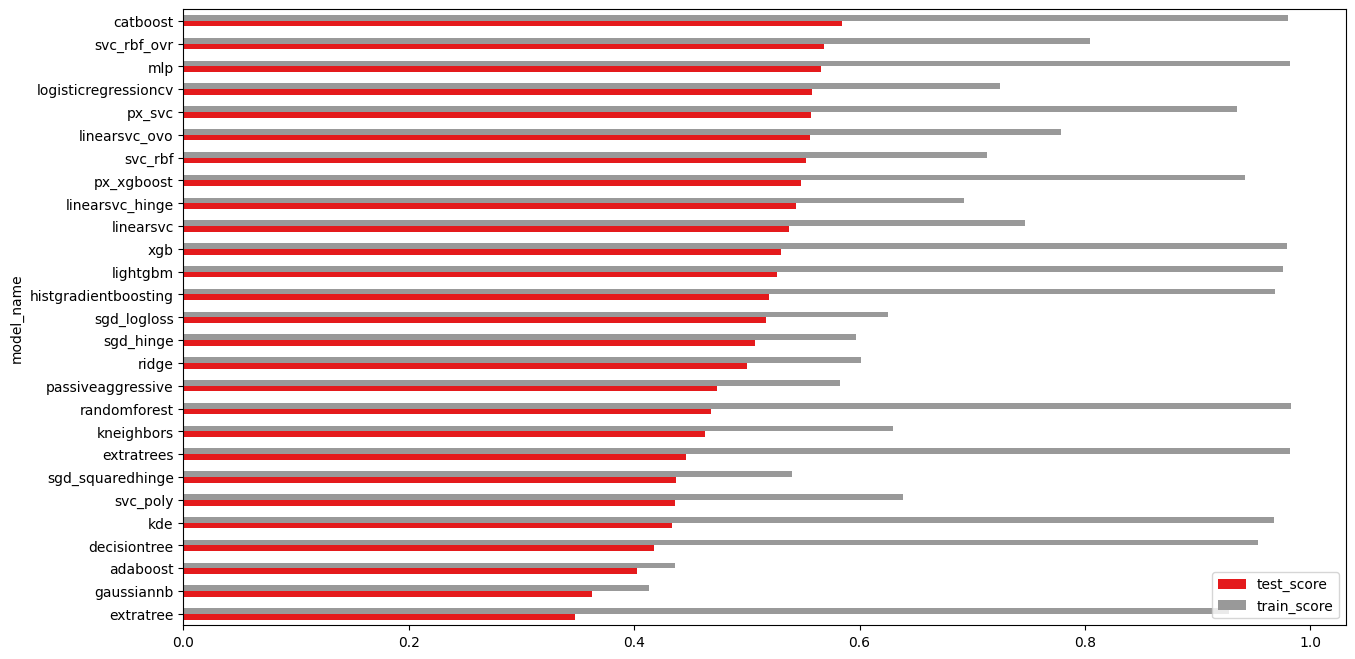

In [9]:
scores_df = pd.read_csv('scores_df.csv', index_col=0)

display(
    scores_df
    .groupby('model_name').mean()
    .assign(test_std=scores_df.groupby('model_name').test_score.std())
    .sort_values('test_score', ascending=False)
    .apply(lambda col_: col_ * 100 if col_.name in ['test_score', 'train_score', 'test_std'] else col_)
    .rename_axis(columns='%')
    [['test_score', 'train_score', 'test_std', 'fit_time', 'score_time',]]

    .style
    .bar('test_score', cmap='Blues', align='left')
    .apply(lambda s: ['color: white; font-weight: normal' if s.name == 'test_score' else None for _ in s])
    .format(precision=1)
)

scores_df.groupby('model_name').mean().sort_values('test_score')[['test_score', 'train_score']].plot.barh(figsize=(15, 8), cmap='Set1');

### Fine-tuning

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform, randint, expon, geom

from model_utils import int_loguniform

- **Preprocessor fine-tuning**

Want a single tuned preprocessor rather than tuning per model

In [11]:
pipeline = make_pipeline(preprocessor, models_dict['mlp'])
# display([p for p in pipeline.get_params() if 'columntransformer' in p])

param_grid = {
    'columntransformer__pipeline-1__tfidfvectorizer__tokenizer': [None, stemming_tokenizer],
    # 'columntransformer__pipeline-1__tfidfvectorizer__stop_words': [None, 'english'],
    'columntransformer__pipeline-1__tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    # 'columntransformer__pipeline-1__tfidfvectorizer__max_df': uniform(0.9, 1.0), #not working?
    'columntransformer__pipeline-1__tfidfvectorizer__min_df': [1, 2, 4, 8, 16],
    # #'max_features': [None],
    # # 'binary': [False],
    'columntransformer__pipeline-1__tfidfvectorizer__dtype': [np.float32, np.float64],
    'columntransformer__pipeline-1__tfidfvectorizer__norm': ['l1', 'l2', None],
    'columntransformer__pipeline-1__tfidfvectorizer__use_idf': [True, False],
    # #smooth_idf, sublinear_tf

    'columntransformer__pipeline-1__pca__n_components': uniform(0.1, 0.999),
    # # 'columntransformer__pipeline-1__pca__whiten'

    #NB bad combo when dropped
    # 'columntransformer__pipeline-2': ['drop', clone(embeddings_features)],
    'columntransformer__pipeline-2__pca__n_components': uniform(0.1, 0.999),
}

np.random.seed(0)

if False:
    tuner = RandomizedSearchCV(
        pipeline, param_grid,
        n_iter=50,
        cv=3,
        scoring='f1_macro',
        n_jobs=6,
        refit=False,
    ).fit(features_df, labels_ser)

    (results_df := pd.DataFrame(tuner.cv_results_)).to_csv('tuner_results_preprocessor.csv')

,6,0,13,44,32
mean_fit_time,110.891048,388.384156,29.074189,9.926794,5.331059
mean_score_time,0.986317,1.960487,0.795098,0.683994,0.575489
param_columntransformer__pipeline-1__pca__n_components,0.71245,0.648265,0.622725,0.948095,0.553243
param_columntransformer__pipeline-1__tfidfvectorizer__dtype,<class 'numpy.float64'>,<class 'numpy.float64'>,<class 'numpy.float64'>,<class 'numpy.float64'>,<class 'numpy.float64'>
param_columntransformer__pipeline-1__tfidfvectorizer__min_df,2,1,4,8,16
param_columntransformer__pipeline-1__tfidfvectorizer__ngram_range,"(1, 2)","(1, 2)","(1, 2)","(1, 2)","(1, 2)"
param_columntransformer__pipeline-1__tfidfvectorizer__norm,l2,l2,l1,l2,l2
param_columntransformer__pipeline-1__tfidfvectorizer__tokenizer,<function stemming_tokenizer at 0x7f8d0c880180>,None,None,<function stemming_tokenizer at 0x7f8d0c880180>,None
param_columntransformer__pipeline-1__tfidfvectorizer__use_idf,True,True,True,False,True
param_columntransformer__pipeline-2__pca__n_components,0.769967,0.397237,0.41825,0.879646,0.555559


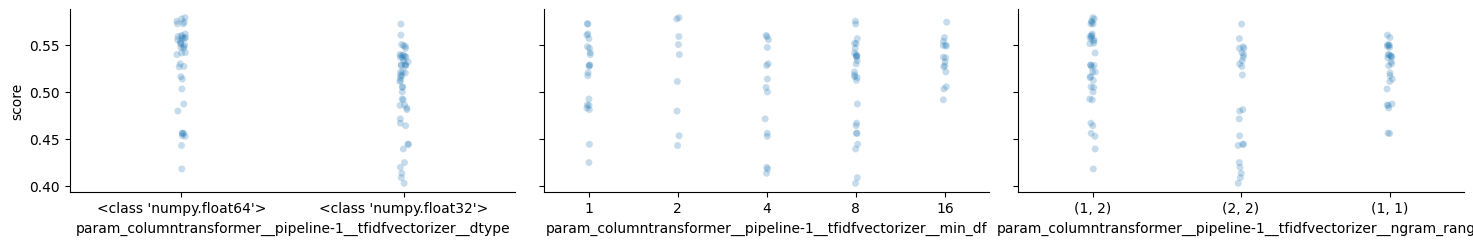

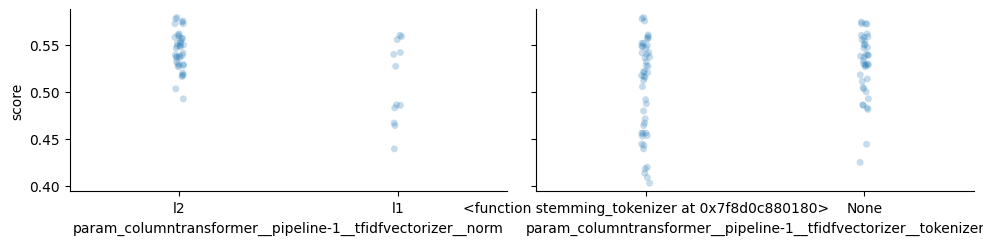

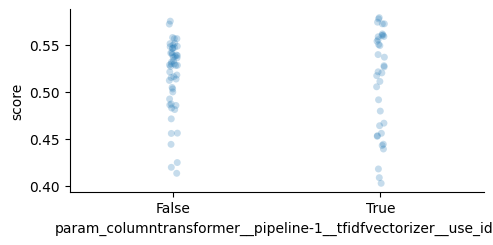

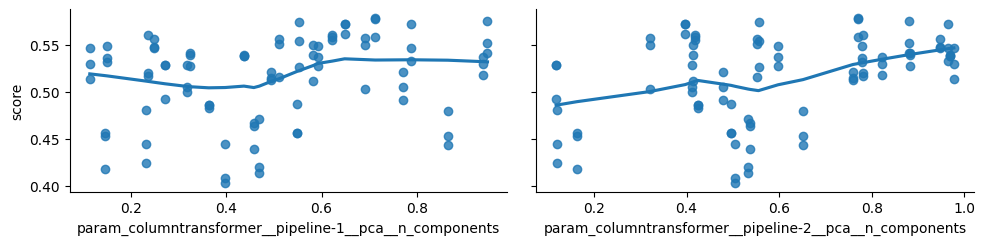

In [12]:
results_df = (
    pd.read_csv('tuner_results_preprocessor.csv', index_col=0)
    .drop(columns=['std_fit_time', 'std_score_time', 'params'])
    .sort_values('mean_test_score', ascending=False)
    .assign(pct_change=lambda df_: df_.mean_test_score.diff().div(df_.mean_test_score).mul(100))
)
results_df.loc[:, 'param_columntransformer__pipeline-1__tfidfvectorizer__tokenizer'] =\
    results_df['param_columntransformer__pipeline-1__tfidfvectorizer__tokenizer'].fillna('None')
display(results_df.iloc[:5].T)

#Melt by split scores to get a row entry/score per fold in a 'score' column
fold_cols = results_df.filter(like='split').columns
results_df_melt = results_df.melt(
    id_vars=[c for c in results_df.columns if not c in fold_cols],
    value_vars=fold_cols,
    var_name='fold', value_name='score',
)

#
# Categorical params
#
for col_sets in [slice(0, 3), slice(3, 5), slice(5, None)]:
    g = sns.PairGrid(
        results_df_melt, y_vars='score',
        x_vars=[
            'param_columntransformer__pipeline-1__tfidfvectorizer__dtype',
            'param_columntransformer__pipeline-1__tfidfvectorizer__min_df',
            'param_columntransformer__pipeline-1__tfidfvectorizer__ngram_range',
            'param_columntransformer__pipeline-1__tfidfvectorizer__norm',
            'param_columntransformer__pipeline-1__tfidfvectorizer__tokenizer',
            'param_columntransformer__pipeline-1__tfidfvectorizer__use_idf',
            # 'param_columntransformer__pipeline-2'
        ][col_sets],
        aspect=2
    )
    g.map(sns.stripplot, alpha=0.25, jitter=0.02, edgecolor='none')
    plt.show()

#
# Continuous params
#
g = sns.PairGrid(
    results_df_melt, y_vars='score',
    x_vars=[
        'param_columntransformer__pipeline-1__pca__n_components',
        'param_columntransformer__pipeline-2__pca__n_components',
    ],
    aspect=2
)
g.map(sns.regplot, x_ci='sd', scatter=True, lowess=True)

#
# Chosen params
#
tuned_params = {
    'columntransformer__pipeline-1__tfidfvectorizer__tokenizer': None,
    'columntransformer__pipeline-1__tfidfvectorizer__ngram_range': (1, 2),
    'columntransformer__pipeline-1__tfidfvectorizer__min_df': 8,
    'columntransformer__pipeline-1__tfidfvectorizer__dtype': np.float64,
    'columntransformer__pipeline-1__tfidfvectorizer__norm': 'l2',
    'columntransformer__pipeline-1__tfidfvectorizer__use_idf': False,
    'columntransformer__pipeline-1__pca__n_components': 0.7,

    'columntransformer__pipeline-2__pca__n_components': 0.8,
    # 'columntransformer__pipeline-2':  #keep
}
preprocessor_tuned_params = {
    k.replace('columntransformer__', ''): v for k, v in tuned_params.items()
}

tuned_estimators = {
    'preprocessor': clone(preprocessor).set_params(**preprocessor_tuned_params)
}

With vs without the sentence embeddings (screenshot 📸):

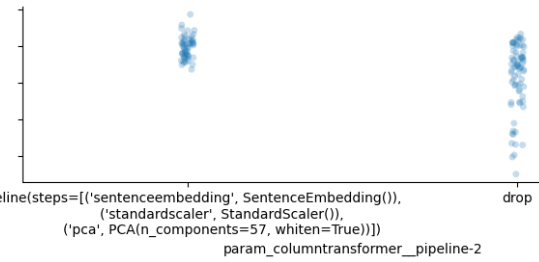

- **XGB fine-tuning**

In [13]:
np.random.seed(0)

pipeline = make_pipeline(tuned_estimators['preprocessor'], models_dict['xgb'])

param_grid = {
    'xgbclassifier__learning_rate': uniform(0.1, 0.9),
    'xgbclassifier__max_depth': randint(1, 7),
    'xgbclassifier__subsample': uniform(1/3, 1),
    'xgbclassifier__lambda': loguniform(0.1, 20),
    'xgbclassifier__loss_guide':  ['depthwise', 'lossguide'],
}

if False:
    tuner = RandomizedSearchCV(
        pipeline, param_grid,
        n_iter=100,
        cv=3,#StratifiedShuffleSplit(1, test_size=1/3, random_state=0),
        scoring='f1_macro',
        n_jobs=-1
    ).fit(features_df, labels_ser)
    (results_df := pd.DataFrame(tuner.cv_results_)).to_csv('tuner_results_xgb.csv')

,81,92,70,40,19,41,74,11,3,46
mean_fit_time,29.799205,19.085746,40.332378,21.198696,24.498095,29.707365,25.504215,37.043362,28.664818,46.179487
mean_score_time,1.077079,0.47334,1.107731,1.036594,1.128131,1.119832,0.517806,1.006998,1.066906,1.159189
param_xgbclassifier__lambda,6.149476,9.411211,0.704895,14.874985,10.616991,0.60258,0.560465,0.197999,8.391552,0.324974
param_xgbclassifier__learning_rate,0.33348,0.511501,0.22321,0.774999,0.926412,0.261541,0.957584,0.383886,0.403657,0.296874
param_xgbclassifier__loss_guide,lossguide,lossguide,lossguide,depthwise,lossguide,depthwise,depthwise,lossguide,depthwise,depthwise
param_xgbclassifier__max_depth,4,3,5,3,3,4,3,5,4,6
param_xgbclassifier__subsample,0.920933,0.909084,0.523181,0.822882,0.898522,0.796784,0.866799,0.90353,0.701575,0.785442
split0_test_score,0.567866,0.534883,0.552701,0.541078,0.54544,0.546459,0.542265,0.531882,0.528656,0.532123
split1_test_score,0.55733,0.575224,0.557621,0.558684,0.569608,0.556266,0.575891,0.571318,0.564361,0.56262
split2_test_score,0.554759,0.554988,0.549041,0.549646,0.532181,0.538821,0.52302,0.533949,0.542326,0.539916


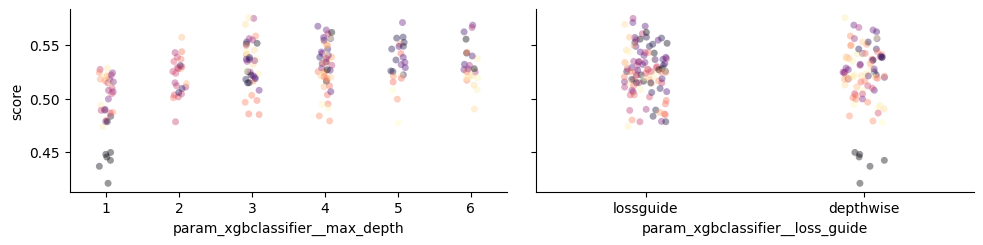

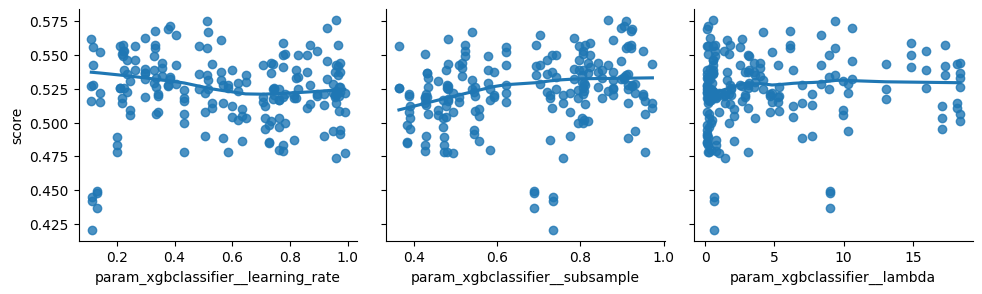

In [14]:
results_df = (
    pd.read_csv('tuner_results_xgb.csv', index_col=0)
    .sort_values('mean_test_score', ascending=False)
    .drop(columns=['std_fit_time', 'std_score_time', 'params'])
)
display(results_df.iloc[:10].T)

fold_cols = results_df.filter(like='split').columns
results_df_melt = results_df.melt(
    id_vars=[c for c in results_df.columns if c not in fold_cols],
    value_vars=fold_cols,
    var_name='fold',
    value_name='score'
)

#
# Categorical params
#
g = sns.PairGrid(
    results_df_melt,
    y_vars='score',
    x_vars=[
        'param_xgbclassifier__max_depth',
        'param_xgbclassifier__loss_guide'
    ],
    aspect=2,
    hue='param_xgbclassifier__learning_rate', palette='magma'
)
g.map(sns.stripplot, alpha=0.4)

#
# Continuous params
#
g = sns.PairGrid(
    results_df_melt,
    y_vars='score',
    x_vars=[
        'param_xgbclassifier__learning_rate',
        'param_xgbclassifier__subsample',
        'param_xgbclassifier__lambda',
    ],
    height=3, aspect=1.1,
    # hue='param_xgbclassifier__learning_rate', palette='magma'
)
g.map(sns.regplot, scatter=True, lowess=True, ci='sd')


#
# Not added to list of tuned models
#

 - **MLP fine-tuning**

In [15]:
np.random.seed(0)

pipeline = make_pipeline(tuned_estimators['preprocessor'], models_dict['mlp'])
# display([p for p in pipeline.get_params() if 'mlpclassifier'  in p])

param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(100,), (300,), (100, 100), (100, 30, 30, 30)],
    'mlpclassifier__activation': ['relu', 'logistic',],
    'mlpclassifier__alpha': loguniform(1e-5, 1e-3),
    'mlpclassifier__batch_size': [8, 16, 32, 64, 128, 256, 512],
    'mlpclassifier__learning_rate': ['constant', 'invscaling',], #NB latter only used when solver='sgd'
    'mlpclassifier__nesterovs_momentum': [True, False],
    'mlpclassifier__early_stopping': [False, True],
}

if False:
    tuner = RandomizedSearchCV(
        pipeline, param_grid,
        n_iter=100,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1,
    ).fit(features_df, labels_ser)

    (results_df := pd.DataFrame(tuner.cv_results_)).to_csv('tuner_results_mlp.csv')

,50,75,91,83,74
mean_fit_time,72.058739,96.696207,74.830495,49.8682,59.643543
mean_score_time,0.922438,0.989334,1.014,0.830258,0.971201
param_mlpclassifier__activation,logistic,logistic,relu,logistic,relu
param_mlpclassifier__alpha,0.000023,0.000018,0.000145,0.00015,0.000353
param_mlpclassifier__batch_size,256,128,512,256,128
param_mlpclassifier__early_stopping,False,False,False,False,False
param_mlpclassifier__hidden_layer_sizes,"(300,)","(300,)","(300,)","(100,)","(300,)"
param_mlpclassifier__learning_rate,invscaling,constant,constant,invscaling,constant
param_mlpclassifier__nesterovs_momentum,False,True,False,True,False
split0_test_score,0.557186,0.557121,0.589063,0.565625,0.56505


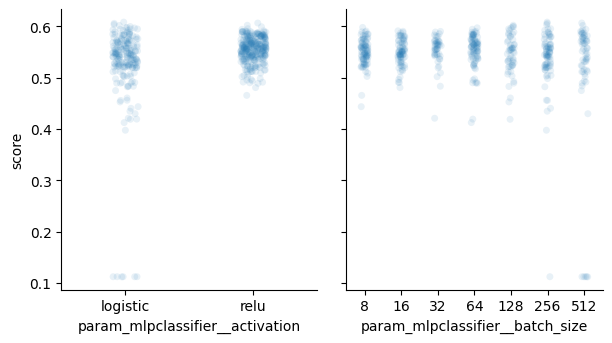

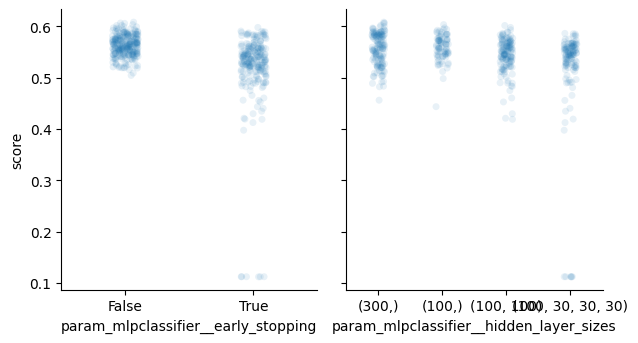

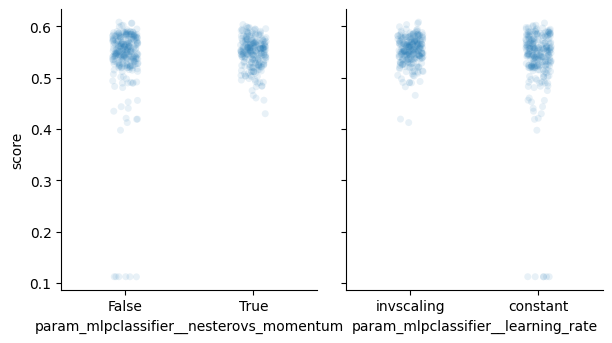

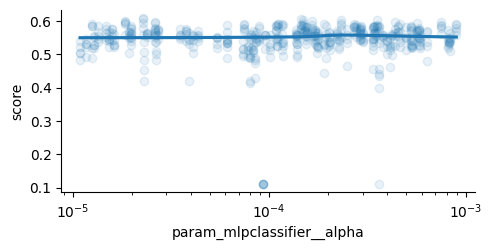

In [16]:
results_df = (
    pd.read_csv('tuner_results_mlp.csv', index_col=0)
    .sort_values('mean_test_score', ascending=False)
    .drop(columns=['std_fit_time', 'std_score_time', 'params'])
)
display(results_df.iloc[:5].T)

fold_cols = results_df.filter(like='split').columns
results_df_melt = results_df.melt(
    id_vars=[c for c in results_df.columns if c not in fold_cols],
    value_vars=fold_cols,
    var_name='fold', value_name='score'
)

#
# Categorical params
#
for col_set in [slice(0, 2), slice(2, 4), slice(4, None)]:
    g = sns.PairGrid(
        results_df_melt, y_vars='score',
        x_vars=[
            'param_mlpclassifier__activation',
            'param_mlpclassifier__batch_size',
            'param_mlpclassifier__early_stopping',
            'param_mlpclassifier__hidden_layer_sizes',
            'param_mlpclassifier__nesterovs_momentum',
            'param_mlpclassifier__learning_rate'
        ][col_set],
        aspect=0.9, height=3.5
    )
    g.map(sns.stripplot, edgecolor='none', alpha=0.1)
    plt.show()

#
# Continuous params
#
g = sns.PairGrid(
    results_df_melt, y_vars='score',
    x_vars=[
        'param_mlpclassifier__alpha',
        # 'param_mlpclassifier__learning_rate'
    ],
    aspect=2
)
g.map(sns.regplot, lowess=True, ci='sd', scatter_kws={'alpha': 0.1})
g.axes[0, 0].set(xscale='log')

#
# Chosen params
#
tuned_params = {
    'mlpclassifier__activation': 'relu',
    'mlpclassifier__batch_size': 64,
    'mlpclassifier__early_stopping': False,
    'mlpclassifier__hidden_layer_sizes': (200,),
    'mlpclassifier__nesterovs_momentum': True,
    'mlpclassifier__learning_rate': 'invscaling',
    'mlpclassifier__alpha': 1e-4,
}
tuned_params = {k.replace('mlpclassifier__', ''): v for k, v in tuned_params.items()}

tuned_estimators['mlp'] = clone(models_dict['mlp']).set_params(**tuned_params)

 - **CustomMLP fine-tuning**

In [17]:
from custom_estimators import CustomMLP
import torch

torch.manual_seed(0)
np.random.seed(0)

pipeline = make_pipeline(
    tuned_estimators['preprocessor'],
    CustomMLP(class_weight='balanced', device='cuda')
)

param_grid = {
    'custommlp__hidden_layer_size': [50, 100, 200, 300, 400],
    'custommlp__n_epochs': int_loguniform(10, 500),
    'custommlp__alpha': loguniform(1e-5, 1e-3),
    'custommlp__batch_size': [8, 16, 32, 64, 128, 256, 512],
    'custommlp__class_weight': [None, 'balanced'],
    'custommlp__nesterovs_momentum': [True, False],
}

if False:
    tuner = RandomizedSearchCV(
        pipeline, param_grid,
        n_iter=100,
        cv=5,
        scoring='f1_macro',
        n_jobs=6,
    ).fit(features_df, labels_ser)

    (results_df := pd.DataFrame(tuner.cv_results_)).to_csv('tuner_results_custommlp.csv')

,45,30,1,8,34,23,71,55,12,88
mean_fit_time,2.930551,2.854408,4.599782,14.836691,15.08717,11.096508,2.699616,14.258102,12.701014,4.701772
mean_score_time,0.234034,0.227012,0.267802,0.17331,0.21633,0.231798,0.165932,0.178335,0.149625,0.205769
param_custommlp__alpha,0.000872,0.000072,0.00007,0.000168,0.000051,0.00001,0.000018,0.000149,0.000016,0.000829
param_custommlp__batch_size,256,512,256,128,512,256,128,128,128,512
param_custommlp__class_weight,balanced,balanced,None,balanced,balanced,None,None,balanced,balanced,balanced
param_custommlp__hidden_layer_size,300,300,400,400,400,300,100,400,400,100
param_custommlp__n_epochs,12,14,32,144,298,157,11,140,129,60
param_custommlp__nesterovs_momentum,False,False,True,True,True,False,False,True,True,False
split0_test_score,0.563073,0.549332,0.562633,0.559924,0.550491,0.567041,0.565652,0.544331,0.54239,0.561955
split1_test_score,0.604233,0.611789,0.611409,0.594257,0.60431,0.588974,0.591422,0.605533,0.585752,0.572656


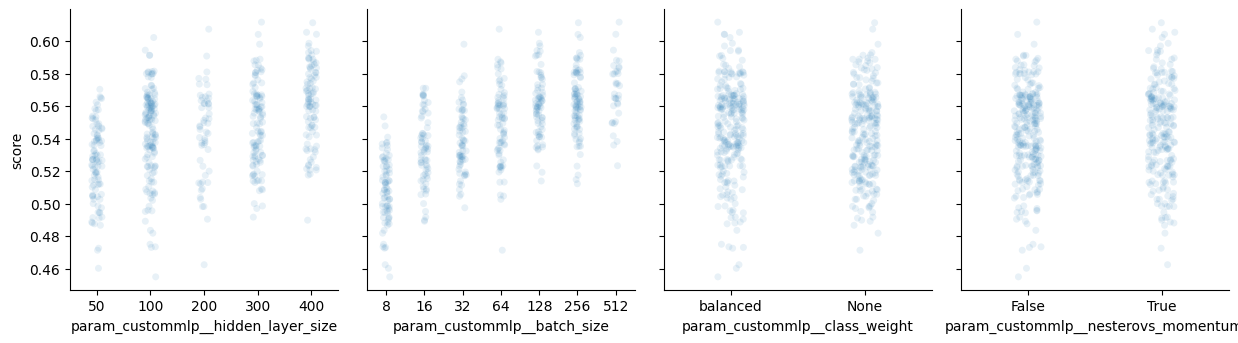

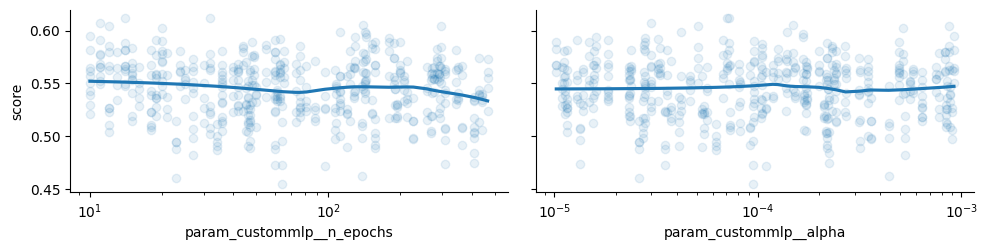

In [18]:
results_df = (
    pd.read_csv('tuner_results_custommlp.csv', index_col=0)
    .assign(param_custommlp__class_weight=lambda df_: df_.param_custommlp__class_weight.replace({np.NaN: 'None'}))
    .sort_values('mean_test_score', ascending=False)
    .drop(columns=['std_fit_time', 'std_score_time', 'params'])
)
display(results_df.iloc[:10].T)

fold_cols = results_df.filter(like='split').columns
results_df_melt = results_df.melt(
    id_vars=[c for c in results_df.columns if c not in fold_cols],
    value_vars=fold_cols,
    var_name='fold', value_name='score'
)

#
# Categorical params
#
g = sns.PairGrid(
    results_df_melt, y_vars='score',
    x_vars=[
        'param_custommlp__hidden_layer_size',
        'param_custommlp__batch_size',
        'param_custommlp__class_weight',
        'param_custommlp__nesterovs_momentum'
    ],
    aspect=0.9, height=3.5
)
g.map(sns.stripplot, edgecolor='none', alpha=0.1)
plt.show()

#
# Continuous params
#
g = sns.PairGrid(
    results_df_melt, y_vars='score',
    x_vars=[
        'param_custommlp__n_epochs',
        'param_custommlp__alpha',
    ],
    aspect=2
)
g.map(sns.regplot, lowess=True, ci='sd', scatter_kws={'alpha': 0.1})
[ax.set(xscale='log') for ax in g.axes.ravel()]

#
# Chosen params
#
tuned_params = {
    'custommlp__batch_size': 256,
    'custommlp__hidden_layer_size': 300,
    'custommlp__alpha': 1e-3,
    'custommlp__class_weight': 'balanced',
    'custommlp__nesterovs_momentum': False,
    'custommlp__n_epochs': 12,

}
tuned_params = {k.replace('custommlp__', ''): v for k, v in tuned_params.items()}

tuned_estimators['custommlp'] = clone(pipeline[-1]).set_params(**tuned_params)

- **SVC rbf ovr fine-tuning**

`svc_rbf_ovr`

In [19]:
np.random.seed(0)

pipeline = make_pipeline(
    tuned_estimators['preprocessor'],
    models_dict['svc_rbf_ovr'],
)
# pipeline.get_params()

param_grid = {
    'onevsrestclassifier__estimator__C': loguniform(1e-2, 1e2),
    'onevsrestclassifier__estimator__gamma': ['scale'],
    'onevsrestclassifier__estimator__tol': uniform(1e-4, 0.1),
}

if False:
    tuner = RandomizedSearchCV(
        pipeline, param_grid,
        n_iter=50,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1,
        refit=False,
    ).fit(features_df, labels_a)
    (results_df := pd.DataFrame(tuner.cv_results_)).to_csv('tuner_results_svc_rbf_ovr.csv')

,44,48,42,6,18
mean_fit_time,80.121625,76.619231,84.706563,81.498748,79.909158
mean_score_time,14.421705,6.121402,14.864047,13.225797,14.500507
param_onevsrestclassifier__estimator__C,2.012732,2.218461,1.84674,1.87145,2.807908
param_onevsrestclassifier__estimator__gamma,scale,scale,scale,scale,scale
param_onevsrestclassifier__estimator__tol,0.09303,0.002111,0.026639,0.09266,0.061793
split0_test_score,0.569232,0.565156,0.563581,0.56555,0.559004
split1_test_score,0.581598,0.579632,0.579847,0.576449,0.579088
split2_test_score,0.590349,0.59233,0.589533,0.585984,0.590036
split3_test_score,0.599401,0.600563,0.595244,0.597226,0.599069
split4_test_score,0.556186,0.548098,0.556629,0.557666,0.555654


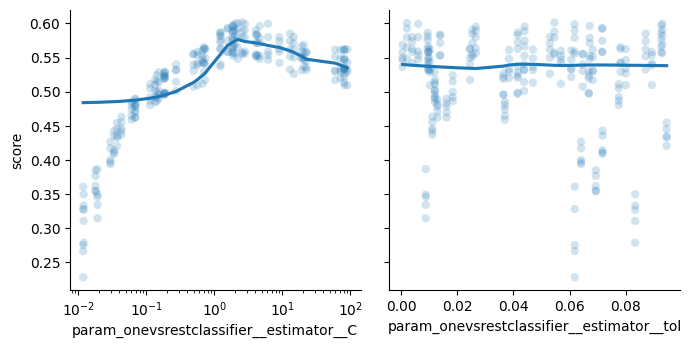

In [20]:
results_df = (
    pd.read_csv('tuner_results_svc_rbf_ovr.csv', index_col=0)
    .sort_values('mean_test_score', ascending=False)
    .drop(columns=['std_fit_time', 'std_score_time', 'params'])
)
display(results_df.iloc[:5].T)

fold_cols = results_df.filter(like='split').columns
results_df_melt = results_df.melt(
    id_vars=[c for c in results_df.columns if c not in fold_cols],
    value_vars=fold_cols,
    var_name='fold', value_name='score',
)

g = sns.PairGrid(
    results_df_melt, y_vars='score',
    x_vars=[
        'param_onevsrestclassifier__estimator__C',
        'param_onevsrestclassifier__estimator__tol'
    ],
    aspect=1, height=3.5
)
g.map(sns.regplot, ci='sd', scatter=True, lowess=True, scatter_kws={'alpha': 0.2, 'edgecolor': 'none'})
g.axes.ravel()[0].set_xscale('log')
plt.show()

#
# Params chosen
#
tuned_params = {
    'onevsrestclassifier__estimator__gamma': 'scale',
    'onevsrestclassifier__estimator__C': 2,
    'onevsrestclassifier__estimator__tol': 1e-3
}
tuned_params = {k.replace('onevsrestclassifier__', ''): v for k, v in tuned_params.items()}

tuned_estimators['svc_rbf_ovr'] = clone(models_dict['svc_rbf_ovr']).set_params(**tuned_params)

- **SVC rbf fine-tuning**

`svc_rbf` (aot `svc_rbf_ovr`) seemed to ensemble better

In [21]:
from sklearnex.svm import SVC as SklearnexSVC #Use for faster tuning

np.random.seed(0)

pipeline = make_pipeline(
    tuned_estimators['preprocessor'],
    # models_dict['svc_rbf'],
    SklearnexSVC().set_params(**models_dict['svc_rbf'].get_params())
)
# pipeline.get_params()

param_grid = {
    'svc__C': loguniform(0.1, 200),
    'svc__gamma': ['scale'], #loguniform(1e-3, 10), #scale 1/276*0.285 = 0.013, auto 1/276 = 0.004 
    'svc__tol': uniform(1e-4, 0.1),
}

if False:
    tuner = RandomizedSearchCV(
        pipeline, param_grid,
        n_iter=50,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1,
        refit=False,
    ).fit(features_df, labels_a)
    (results_df := pd.DataFrame(tuner.cv_results_)).to_csv('tuner_results_svc_rbf.csv')

,0,14,43,44,48
mean_fit_time,32.127192,31.625128,31.519762,30.102799,21.919351
mean_score_time,1.138515,0.839323,1.108169,1.27042,0.371153
param_svc__C,6.481117,5.280037,5.336512,7.965566,8.631709
param_svc__gamma,scale,scale,scale,scale,scale
param_svc__tol,0.071619,0.041566,0.009494,0.09303,0.002111
split0_test_score,0.560921,0.551088,0.549077,0.558943,0.556825
split1_test_score,0.575669,0.581364,0.582513,0.568438,0.568828
split2_test_score,0.577776,0.585362,0.582937,0.57947,0.57715
split3_test_score,0.5912,0.581357,0.583264,0.585773,0.588395
split4_test_score,0.544697,0.549732,0.547041,0.55192,0.550004


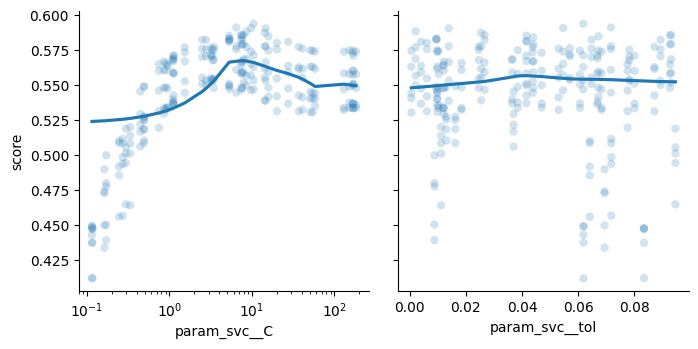

In [22]:
results_df = (
    pd.read_csv('tuner_results_svc_rbf.csv', index_col=0)
    .sort_values('mean_test_score', ascending=False)
    .drop(columns=['std_fit_time', 'std_score_time', 'params'])
)
display(results_df.iloc[:5].T)

fold_cols = results_df.filter(like='split').columns
results_df_melt = results_df.melt(
    id_vars=[c for c in results_df.columns if c not in fold_cols],
    value_vars=fold_cols,
    var_name='fold', value_name='score',
)

g = sns.PairGrid(
    results_df_melt, y_vars='score',
    x_vars=['param_svc__C', 'param_svc__tol'],
    aspect=1, height=3.5
)
g.map(sns.regplot, ci='sd', scatter=True, lowess=True, scatter_kws={'alpha': 0.2, 'edgecolor': 'none'})
g.axes.ravel()[0].set_xscale('log')
plt.show()

#
# Params chosen
#
tuned_params = {
    'svc__gamma': 'scale',
    'svc__C': 10,
    'svc__tol': 1e-3
}
tuned_params = {k.replace('svc__', ''): v for k, v in tuned_params.items()}

#Save it to sklearn's SVC aot sklearnex (latter only for faster tuning)
tuned_estimators['svc_rbf'] = clone(models_dict['svc_rbf']).set_params(**tuned_params)

- **CatBoost fine-tuning**

In [23]:
np.random.seed(0)

pipeline = make_pipeline(tuned_estimators['preprocessor'], models_dict['catboost'])

param_grid = {
    'modifiedcatboostclassifier__loss_function': ['MultiClass', 'MultiClassOneVsAll'],

    'modifiedcatboostclassifier__iterations': int_loguniform(100, 5_000),
    # 'modifiedcatboostclassifier__learning_rate': [None]
    'modifiedcatboostclassifier__depth': randint(3, 5),
    'modifiedcatboostclassifier__rsm': uniform(0.1, 1.),
    'modifiedcatboostclassifier__l2_leaf_reg': loguniform(0.3, 30.),
    'modifiedcatboostclassifier__border_count': [64, 128, 254],
    # 'modifiedcatboostclassifier__grow_policy': ['SymmetricTree', 'DepthWise', 'Lossguide']
}

if False:
    tuner = RandomizedSearchCV(
        pipeline, param_grid,
        n_iter=50,
        cv=3,
        scoring='f1_macro',
        n_jobs=-1,
        refit=False,
    ).fit(features_df, labels_ser)

    (results_df := pd.DataFrame(tuner.cv_results_)).to_csv('tuner_results_catboost.csv')

,11,8,26,39,28
mean_fit_time,1556.485466,1360.927342,1584.515552,714.07648,872.285796
std_fit_time,3.911782,13.636216,1.626256,5.851277,15.225739
mean_score_time,16.395414,19.501148,1.135586,2.078236,8.337566
std_score_time,1.033797,3.709685,0.761545,0.303915,2.121611
param_modifiedcatboostclassifier__border_count,64,128,254,64,128
param_modifiedcatboostclassifier__depth,4,4,4,3,3
param_modifiedcatboostclassifier__iterations,4778,3416,4211,4853,3108
param_modifiedcatboostclassifier__l2_leaf_reg,0.479966,2.382436,5.822395,1.027179,0.481779
param_modifiedcatboostclassifier__loss_function,MultiClassOneVsAll,MultiClassOneVsAll,MultiClass,MultiClass,MultiClass
param_modifiedcatboostclassifier__rsm,0.735059,0.537032,0.718809,0.635633,0.669965


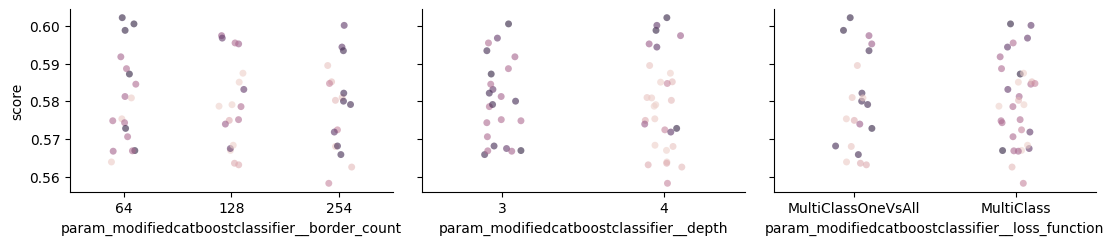

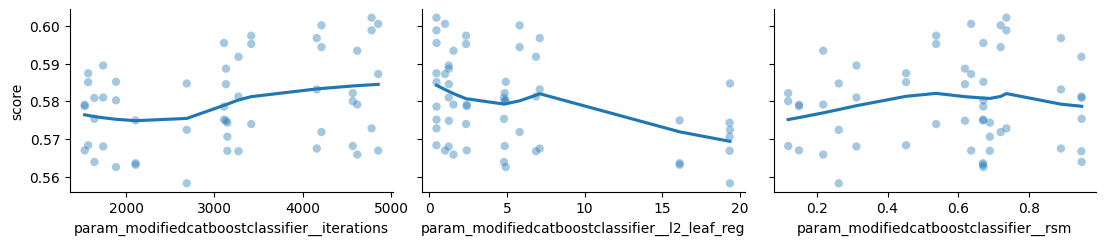

In [24]:
results_df = (
    pd.read_csv('tuner_results_catboost.csv', index_col=0)
    .sort_values('mean_test_score', ascending=False)
    .drop(columns='params')
    .loc[lambda df_: df_.param_modifiedcatboostclassifier__iterations.gt(1500)]
)
display(results_df.iloc[:5].T)

fold_cols = results_df.filter(like='split').columns
results_df_melt = results_df.melt(
    id_vars=[c for c in results_df.columns if c not in fold_cols],
    value_vars=fold_cols,
    var_name='fold', value_name='score'
)

#
# Categorical parameters
#
g = sns.PairGrid(
    results_df_melt, y_vars='score',
    x_vars=[
        'param_modifiedcatboostclassifier__border_count',
        'param_modifiedcatboostclassifier__depth',
        'param_modifiedcatboostclassifier__loss_function'
    ],
    hue='param_modifiedcatboostclassifier__iterations',
    aspect=1.5,
)
g.map(sns.stripplot, alpha=0.6, edgecolor='none', jitter=0.12,)
plt.show()

#
# Continuous parameters
#
g = sns.PairGrid(
    results_df_melt, y_vars='score',
    x_vars=[
        'param_modifiedcatboostclassifier__iterations',
        'param_modifiedcatboostclassifier__l2_leaf_reg',
        'param_modifiedcatboostclassifier__rsm',
    ],
    aspect=1.5,
)
g.map(sns.regplot, scatter=True, ci='sd', lowess=True, scatter_kws={'alpha': 0.4, 'edgecolor': 'none'})


#
# Params chosen
#
tuned_params = {
    'modifiedcatboostclassifier__iterations': 3000,
    'modifiedcatboostclassifier__loss_function': 'MultiClass',
    'modifiedcatboostclassifier__rsm': 0.7,
    'modifiedcatboostclassifier__l2_leaf_reg': 3.0,
    'modifiedcatboostclassifier__border_count': 254,
    'modifiedcatboostclassifier__depth': 6,
}
tuned_params = {k.replace('modifiedcatboostclassifier__', ''): v for k, v in tuned_params.items()}

tuned_estimators['catboost'] = clone(models_dict['catboost']).set_params(**tuned_params)

For catboost isolate depth/iters & assess trend

In [25]:
from sklearn.model_selection import ValidationCurveDisplay

if False:
    #15min run time | 42m
    vcd = ValidationCurveDisplay.from_estimator(
        pipeline, features_df, labels_a,
        # param_name='modifiedcatboostclassifier__depth', param_range=range(3, 11),
        param_name='modifiedcatboostclassifier__iterations', param_range=np.arange(2000, 7000, step=250),
        cv=StratifiedShuffleSplit(1, test_size=1/4),
        scoring='f1_macro',
        n_jobs=-1
    )

Screenshots from a previous run:

<u>Depth:

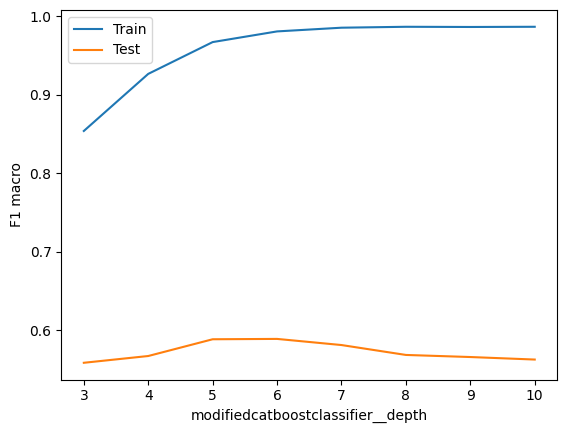

<u>Iterations (zoomed):

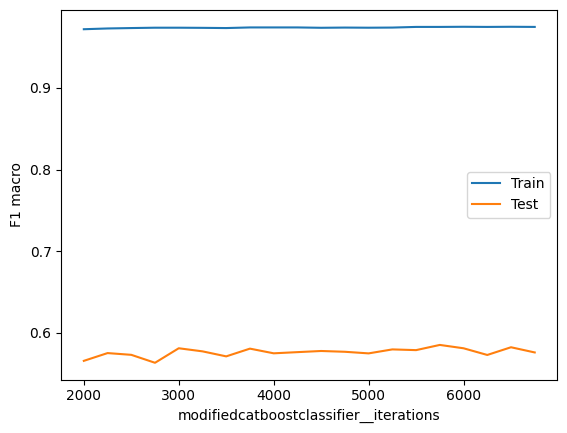 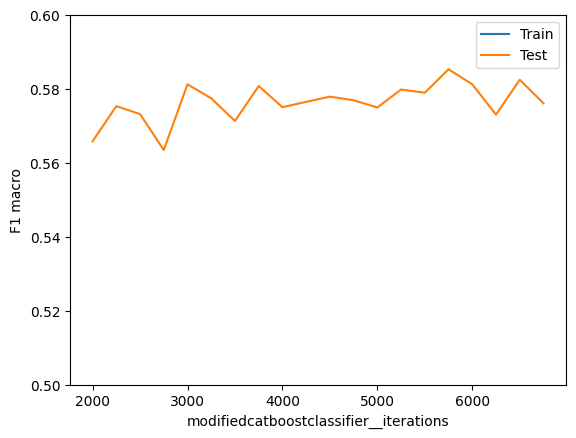

### Fit tuned estimators over K folds

In [26]:
cv = StratifiedKFold(5)

# scores_dfs = []
for model_name in filter(lambda x: x != 'preprocessor', tuned_estimators):
    if (skip := True):
        continue

    print(model_name.center(85, '`'))

    pipeline = make_pipeline(
        tuned_estimators['preprocessor'], tuned_estimators[model_name]
    )

    scores = cross_validate(
        pipeline,
        features_df, labels_ser,
        scoring='f1_macro',
        cv=cv,
        n_jobs=10,
        return_estimator=True,
        return_train_score=True,
    )

    with open(f'cv_estimators_tuned/{model_name}.pickle', 'wb') as f:
        dill.dump(scores.pop('estimator'), f)

    scores_dfs.append(pd.DataFrame(scores).assign(model=model_name))

if not skip:
    scores_df = pd.concat(scores_dfs, axis=0).reset_index(drop=True).to_csv('scores_df_tuned.csv')

scores_df = pd.read_csv('scores_df_tuned.csv', index_col=0)

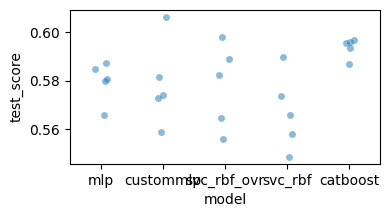

In [27]:
(
    scores_df
    .groupby('model').mean()
    .sort_values('test_score', ascending=False)
)

ax = sns.stripplot(
    scores_df,
    x=scores_df.model,
    y='test_score',
    alpha=0.5,
)
# sns.boxplot(scores_df, x=scores_df.model, y='test_score', fill=False, width=0.1)
ax.figure.set_size_inches(4, 2)

### Get OOF scores

For assessing class-specific performance

Use fitted estimators rather than re-fitting via `cross_val_predict`

In [28]:
predictions_dict = {}

oof_ixs = np.concatenate([
    val_ixs for (_, val_ixs) in cv.split(features_df, labels_ser)
])

print('Getting OOF preds for CV-fitted pipelines'.center(85, '`'))
for pickle_path in Path('cv_estimators_tuned').glob('*.pickle'):
    model_name = pickle_path.stem
    print(model_name, '...')
    
    with open(pickle_path, 'rb') as f:
        cv_estimators = dill.load(f)

    predictions = np.concatenate([
        pipeline.predict(features_df.iloc[val_ixs])
        for (pipeline, (_, val_ixs))
        in zip(cv_estimators, cv.split(features_df, labels_ser))
    ]).ravel()

    predictions_dict[model_name] = predictions

predictions_df = pd.DataFrame(predictions_dict, index=oof_ixs).join(labels_ser.to_frame())
predictions_df

``````````````````````Getting OOF preds for CV-fitted pipelines``````````````````````
custommlp ...


Map:   0%|          | 0/1110 [00:00<?, ? examples/s]

Map:   0%|          | 0/1110 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

svc_rbf ...


Map:   0%|          | 0/1110 [00:00<?, ? examples/s]

Map:   0%|          | 0/1110 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

mlp ...


Map:   0%|          | 0/1110 [00:00<?, ? examples/s]

Map:   0%|          | 0/1110 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

catboost ...


Map:   0%|          | 0/1110 [00:00<?, ? examples/s]

Map:   0%|          | 0/1110 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

svc_rbf_ovr ...


Map:   0%|          | 0/1110 [00:00<?, ? examples/s]

Map:   0%|          | 0/1110 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

,custommlp,svc_rbf,mlp,catboost,svc_rbf_ovr,labels_encoded
0,1,0,0,0,0,1
1,1,0,1,1,1,1
2,1,1,1,1,1,1
3,1,3,1,1,3,1
4,1,1,1,0,1,1
...,...,...,...,...,...,...
5542,4,4,3,4,3,3
5543,1,0,2,3,0,0
5544,0,1,1,1,1,1
5545,3,4,2,3,4,3


In [29]:
#Correlation with target
(
    predictions_df.corr()
    .iloc[:-1, [-1]].replace({1: np.nan})
    .sort_values('labels_encoded', ascending=False)
    .style
    # .background_gradient('Reds')
    .format(precision=3)
    .pipe(display)
)

#Model correlations
predictions_df.iloc[:, :-1].corr(method='spearman').round(2).replace({1: np.nan})

,labels_encoded
catboost,0.775
mlp,0.773
custommlp,0.768
svc_rbf_ovr,0.762
svc_rbf,0.756


,custommlp,svc_rbf,mlp,catboost,svc_rbf_ovr
custommlp,NaN,0.81,0.83,0.84,0.82
svc_rbf,0.81,NaN,0.84,0.83,0.90
mlp,0.83,0.84,NaN,0.84,0.84
catboost,0.84,0.83,0.84,NaN,0.85
svc_rbf_ovr,0.82,0.90,0.84,0.85,NaN


### Ensemble models using `predictions_df` predictions

Extra weights for catboost/prefer catboost in tie - not used

31


,ensemble,fold0,fold1,fold2,fold3,fold4,ensemble_size,mean_score
30,"('custommlp', 'svc_rbf', 'mlp', 'catboost', 'svc_rbf_ovr')",0.587393,0.600865,0.615739,0.616716,0.587894,5,0.601721
16,"('custommlp', 'svc_rbf', 'catboost')",0.591467,0.597511,0.604137,0.616972,0.589410,3,0.599899
27,"('custommlp', 'svc_rbf', 'catboost', 'svc_rbf_ovr')",0.580413,0.595954,0.612101,0.621444,0.582555,4,0.598493
21,"('svc_rbf', 'mlp', 'catboost')",0.590962,0.606601,0.603050,0.591040,0.589432,3,0.596217
25,"('custommlp', 'svc_rbf', 'mlp', 'catboost')",0.583487,0.589756,0.601001,0.612568,0.593622,4,0.596087
26,"('custommlp', 'svc_rbf', 'mlp', 'svc_rbf_ovr')",0.572528,0.595097,0.601997,0.616008,0.593148,4,0.595755
24,"('mlp', 'catboost', 'svc_rbf_ovr')",0.591511,0.598861,0.599521,0.601840,0.586832,3,0.595713
20,"('custommlp', 'catboost', 'svc_rbf_ovr')",0.581072,0.594536,0.604721,0.604803,0.589243,3,0.594875
19,"('custommlp', 'mlp', 'svc_rbf_ovr')",0.573899,0.596541,0.604347,0.603195,0.596197,3,0.594836
28,"('custommlp', 'mlp', 'catboost', 'svc_rbf_ovr')",0.576220,0.589121,0.602688,0.607240,0.597437,4,0.594541


svc_rbf        5
catboost       5
custommlp      4
mlp            3
svc_rbf_ovr    2
Name: number of mentions, dtype: int64

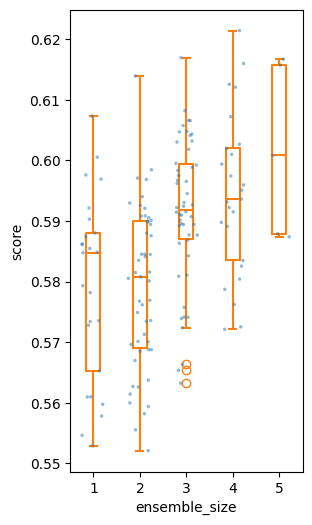

In [30]:
from itertools import combinations
from sklearn.metrics import f1_score

to_ensemble = [
    'svc_rbf_ovr', 'catboost', 'mlp',
    'logisticregressioncv', 'svc_rbf', 'linearsvc_ovo', 'linearsvc_hinge',
    'lightgbm', 'linearsvc',
]
to_ensemble = predictions_df.columns.drop('labels_encoded')

combs = sum([
    list(combinations(to_ensemble, r=size)) for size in range(len(to_ensemble) + 1)
], [])[1:]
print(len(combs))

def majority_vote(ser_):
    if ser_.nunique() == ser_.index.size:
        return np.random.choice(ser_.unique()) #pick one at random
    return ser_.value_counts(ascending=False).index[0]

scores = []
for model_names in combs:
    fold_scores = [
        f1_score(
            predictions_df['labels_encoded'].iloc[val_ixs],
            predictions_df[list(model_names)].iloc[val_ixs].apply(majority_vote, axis=1),
            average='macro'
        )
        for (_, val_ixs) in cv.split(features_df, labels_ser)
    ]

    scores.append(fold_scores)

ens_df = (
    pd.DataFrame(scores, index=combs, columns=[f'fold{i}' for i in range(cv.n_splits)])
    .reset_index(names='ensemble')
    .assign(
        ensemble_size=[len(ens) for ens in combs],
        mean_score=lambda df_: df_.filter(regex='fold*').mean(axis=1)
    )
    .sort_values('mean_score', ascending=False)
    .pipe(
        lambda df_: df_.style.bar('mean_score', align='left').pipe(display) or df_
    )
)

ens_melt = ens_df.melt(
    id_vars=['ensemble', 'mean_score', 'ensemble_size'],
    value_vars=ens_df.filter(regex='fold*').columns,
    var_name='fold', value_name='score'
).sort_values('mean_score', ascending=False)
# display(ens_melt)

ax = sns.stripplot(
    ens_melt, x='ensemble_size', y='score',
    marker='.', edgecolor='none', alpha=0.5, jitter=0.25
)
sns.boxplot(ens_melt, x='ensemble_size', y='score', fill=False, width=0.3)
ax.figure.set_size_inches(3, 6)

#Mentions in top k ensembles
pd.Series(sum(ens_df.iloc[:5].ensemble.to_list(), ())).value_counts().rename('number of mentions')

### Class scores per model

In [31]:
print('Updated predictions_df with ensemble preds')

predictions_df = predictions_df.assign(
    ensemble=predictions_df.drop(columns=['svc_rbf_ovr', 'custommlp', 'labels_encoded']).apply(majority_vote, axis=1)
)
predictions_df

Updated predictions_df with ensemble preds


,custommlp,svc_rbf,mlp,catboost,svc_rbf_ovr,labels_encoded,ensemble
0,1,0,0,0,0,1,0
1,1,0,1,1,1,1,1
2,1,1,1,1,1,1,1
3,1,3,1,1,3,1,1
4,1,1,1,0,1,1,1
...,...,...,...,...,...,...,...
5542,4,4,3,4,3,3,4
5543,1,0,2,3,0,0,0
5544,0,1,1,1,1,1,1
5545,3,4,2,3,4,3,2


- Current BERT scores from https://the-strategy-unit.github.io/PatientExperience-QDC/pxtextmining/model_performance.html

In [32]:
print('Current BERT macro averages:')
print(' precision:', np.mean([0.8, 0.63, 0.52, 0.79, 0.52]))
print(' recall:   ', np.mean([0.79, 0.52, 0.71, 0.68, 0.64]))
print(' F1:       ', np.mean([0.8, 0.57, 0.6, 0.73, 0.57]))

Current BERT macro averages:
 precision: 0.652
 recall:    0.668
 F1:        0.654


Ensemble scores a bit better on the class=4 label, but I don't think it's worth the complexity vs just catboost

Catboost is similar to BERT except for: class 4 *recall* a lot worse with cb (and neural comments often misclassified)

Neutrals often misclassified into adajacent +/- labels

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~custommlp~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      2169
           1       0.57      0.57      0.57      1271
           2       0.40      0.40      0.40       645
           3       0.70      0.74      0.72      1231
           4       0.47      0.42      0.44       231

    accuracy                           0.65      5547
   macro avg       0.58      0.58      0.58      5547
weighted avg       0.65      0.65      0.65      5547

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~svc_rbf~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      2169
           1       0.55      0.60      0.57      1271
           2       0.38      0.35      0.36       645
           3       0.70      0.70      0.70      1231
           4       0.46      0.44      0.45       231

    accuracy 

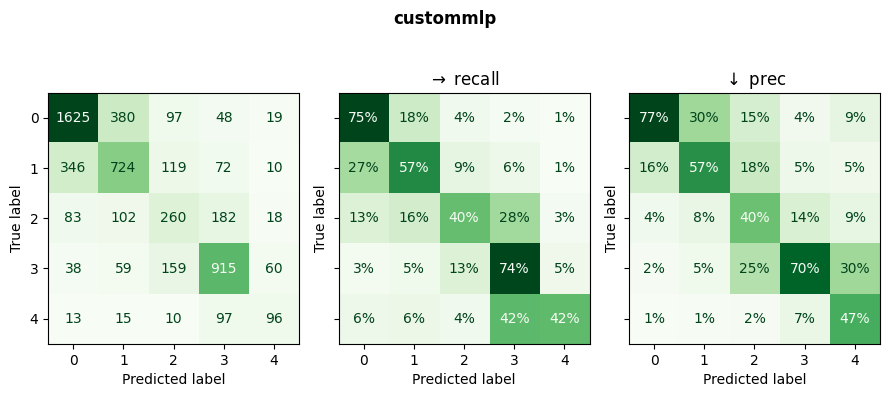

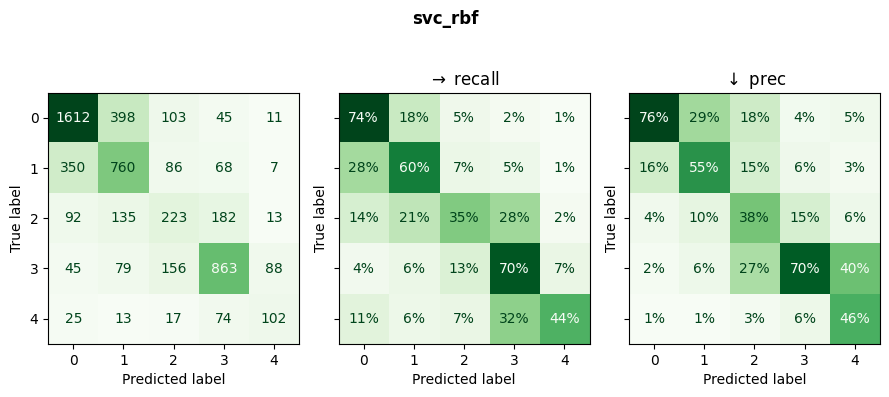

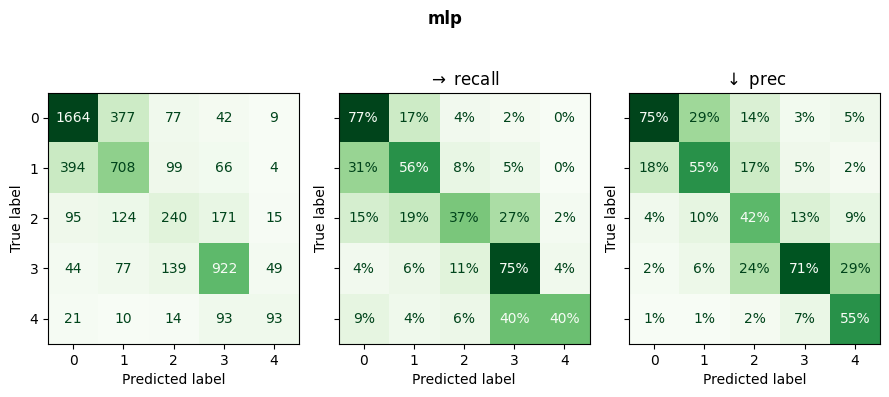

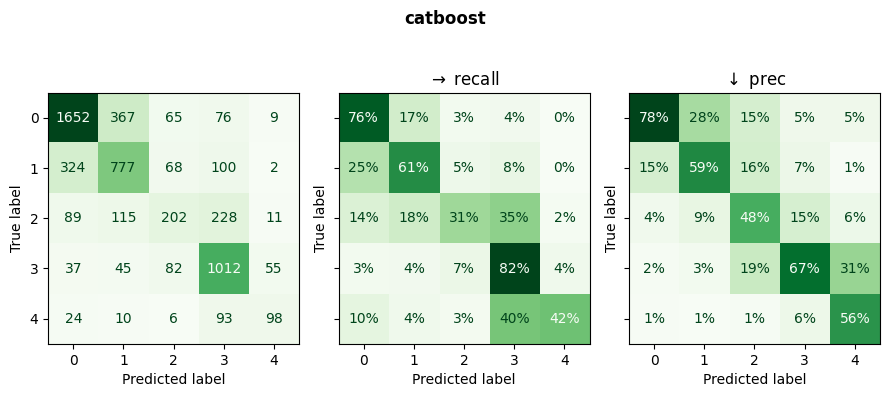

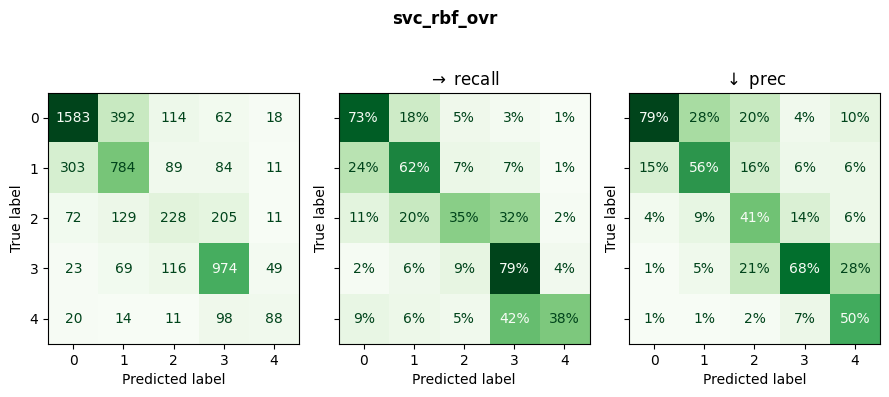

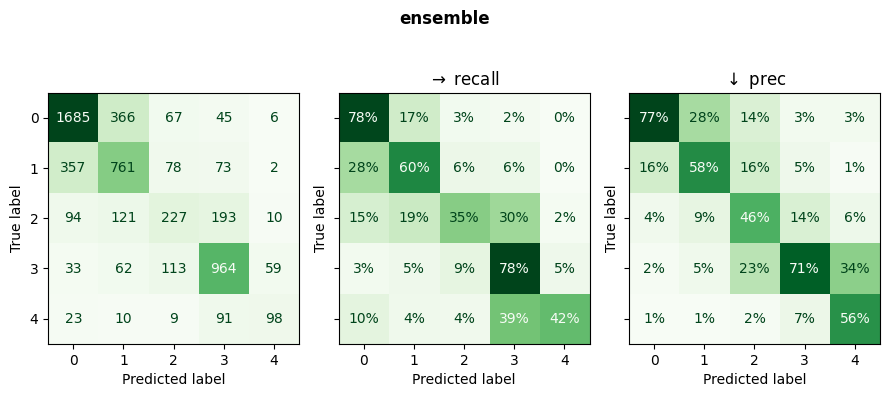

In [33]:
#
# Confusion matrix display
#
from sklearn.metrics import ConfusionMatrixDisplay

for model_name in predictions_df.drop(columns='labels_encoded'):
    f, axs = plt.subplots(figsize=(9, 4), ncols=3, layout='tight', sharex=True, sharey=True)

    for norm, ax in zip([None, 'true', 'pred'], axs):
        d = ConfusionMatrixDisplay.from_predictions(
            y_true=predictions_df.labels_encoded,
            y_pred=predictions_df[model_name],
            include_values=True,
            cmap='Greens',
            normalize=norm,
            values_format='.0%' if norm is not None else None,
            colorbar=False,
            ax=ax
        )
        if norm:
            d.ax_.set_title(r'$\rightarrow$ recall' if norm=='true' else r'$\downarrow$ prec')
        f.suptitle(model_name, weight='bold')

#
# Classification report
#
from sklearn.metrics import classification_report

for model_name in predictions_df.drop(columns='labels_encoded'):
    print(model_name.center(85, '~'))
    print(classification_report(
        y_true=predictions_df.labels_encoded,
        y_pred=predictions_df[model_name],
        digits=2
    ))

### Test set score

Use CatBoost model

In [46]:
np.random.seed(10)

if False:
    print(classification_report(
        y_true=df_tweak_sent['Comment sentiment'].sub(1).iloc[test_ixs],
        y_pred=
        clone(make_pipeline(tuned_estimators['preprocessor'], tuned_estimators['catboost']))
        .fit(features_df, labels_a)
        .predict(df_tweak_sent.drop(columns='Comment sentiment').iloc[test_ixs])
    ))

"""
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       241
           1       0.57      0.57      0.57       141
           2       0.45      0.32      0.37        72
           3       0.67      0.86      0.76       137
           4       0.59      0.38      0.47        26

    accuracy                           0.67       617
   macro avg       0.61      0.58      0.59       617
weighted avg       0.66      0.67      0.66       617
"""

Records will be trucated to 512 tokens


Map:   0%|          | 0/5547 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (844 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/617 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       241
           1       0.57      0.57      0.57       141
           2       0.45      0.32      0.37        72
           3       0.67      0.86      0.76       137
           4       0.59      0.38      0.47        26

    accuracy                           0.67       617
   macro avg       0.61      0.58      0.59       617
weighted avg       0.66      0.67      0.66       617



---
# **Appendix**

1. Feature dimensionality
   - Ended up relying on random search mainly, but was good for an initial preproc
2. Class weight boosting for class=4
    - Helped boost recall for class=4 without degradation
    - Ok with SVC but not catboost.
3. Threshold tuning, particularly for class=4
    - Precipitous drop in prec for class=4
    - Usable for class=2 if required
    - BERT's PR curve much higher
4. Hierarchical classification (2 versions: by strength, by sentiment)
    - Strength didn't help
    - Sentiment didn't help much. Class 4 recall almost the same.
5. Custom MLP that supports class weights
    - Better overall in terms of recall (class 0 a bit less)

### 1. Assess feature dimensionality

PCA begins to flatten ~1400. $\lambda_{max}=0.4$

For embeddings, 98% at ~300 out of 768. $\lambda>1.9$ for 57 components (2 &  75 bert large, 1.5 27 for tinybert)

$
\lambda^+ = \left(1 + \sqrt\frac{n_{features}}{n_{samples}}\right)^2
$

1.9 for embedding features, ~2.8 for tfidf.

LDA useful throughout

Records will be trucated to 512 tokens


Map:   0%|          | 0/5547 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (844 > 512). Running this sequence through the model will result in indexing errors


LDA cumulative EVR %: [ 57.  78.  91. 100.]


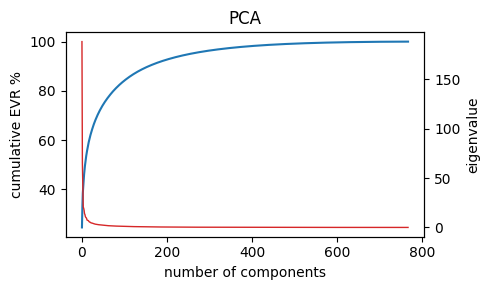

In [34]:
#
# PCA dimensionality assessment
#
tfmd = clone(tfidf_features[:-1]).fit_transform(features_df['answer_clean'])
tfmd = clone(embeddings_features[:-1]).fit_transform(features_df[['answer_clean']])
# tfmd = clone(preprocessor).fit_transform(features_df)
pca = PCA().fit(tfmd)

#Plot cumulative EVR, and eigenvalues
f, ax = plt.subplots(figsize=(5, 3), layout='tight')

ax.plot(np.cumsum(pca.explained_variance_ratio_) * 100)
ax.set(xlabel='number of components', ylabel='cumulative EVR %', title='PCA')

(ax2 := ax.twinx()).plot(pca.explained_variance_, color='tab:red', linewidth=1)
ax2.set_ylabel('eigenvalue')

#
# LDA assessment
#
lda = LinearDiscriminantAnalysis().fit(tfmd, labels_a)
print('LDA cumulative EVR %:', np.cumsum(lda.explained_variance_ratio_ * 100).round())

### 2. Further exploration of class balancing

 - downweight = 0.5 helps with svc_rbf. Classes mostly same except 4 improves recall.
 - catboost worse with downweight

In [35]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.utils import compute_class_weight

sk_bal =  {k: compute_class_weight('balanced', classes=np.unique(labels_a), y=labels_a)[k] for k in range(5)}

clf_reports = []
downweights = np.arange(0.1, 1.1, step=0.1)
for downweight in downweights:
    continue

    print(str(downweight).center(85, '~'))

    class_proportions = np.bincount(labels_a) * np.unique(labels_a).size / len(labels_a)
    balanced_skewed = {
        clas: (1. if clas==4 else downweight) * 1./proportion for clas, proportion in enumerate(class_proportions) 
    }

    pipeline = make_pipeline(tuned_estimators['preprocessor'], tuned_estimators['svc_rbf'])
    pipeline.set_params(**dict(svc__class_weight=balanced_skewed))

    clf_report = classification_report(
        labels_a,
        cross_val_predict(pipeline, features_df, labels_a, cv=3, n_jobs=-1), digits=3
    )

    clf_reports.append(clf_report)
    print(clf_report)

In [36]:
""" svc_rbf downweight=0.5
             precision    recall  f1-score   support

           0      0.763     0.720     0.741      2169
           1      0.533     0.592     0.561      1271
           2      0.379     0.353     0.366       645
           3      0.708     0.702     0.705      1231
           4      0.403     0.468     0.433       231

    accuracy                          0.633      5547
   macro avg      0.557     0.567     0.561      5547
weighted avg      0.639     0.633     0.635      5547
"""

if clf_reports:
  for c, v in zip(clf_reports, np.arange(0.1, 1.1, step=0.1)):
      print(str(v).center(85, '~'))
      print(c)

### 3. Threshold tuning

To get recall on class 4 similar to DistilBERT, prec=0.2

Doesn't look like worth tuning thresholds here since it's a steep tradeoff with prec.

For class 2, can tune threshold for similar prec but much higher recall.

In [37]:
np.random.seed(0)

pipeline = clone(
    make_pipeline(tuned_estimators['preprocessor'], tuned_estimators['svc_rbf'])
).set_params(**{'svc__probability': True})

#Train-val split
trn_ixs, val_ixs = next(StratifiedShuffleSplit(1, test_size=1/3).split(features_df, labels_a))

Xtrn, ytrn = features_df.iloc[trn_ixs], labels_a[trn_ixs]
Xval, yval = features_df.iloc[val_ixs], labels_a[val_ixs]

#Regular approach (current)
pipeline.fit(Xtrn, ytrn)

preds_default = pipeline.predict(Xval)
probas_default = pipeline.predict_proba(Xval)
print(classification_report( y_true=yval, y_pred=preds_default ))

# for format in ['ovo', 'ovr']:
#     pipeline.set_params(**{'svc__decision_function_shape': format})
#     decfunc = pipeline.decision_function(features_df.iloc[trn_ixs])
#     display(decfunc.shape, decfunc[0, :])
#
# print('predicted', pipeline.predict(features_df.iloc[0:1]) )

Records will be trucated to 512 tokens


Map:   0%|          | 0/3698 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (844 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/1849 [00:00<?, ? examples/s]

Map:   0%|          | 0/1849 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       723
           1       0.55      0.56      0.56       424
           2       0.35      0.29      0.32       215
           3       0.70      0.73      0.71       410
           4       0.41      0.39      0.40        77

    accuracy                           0.63      1849
   macro avg       0.55      0.54      0.54      1849
weighted avg       0.63      0.63      0.63      1849



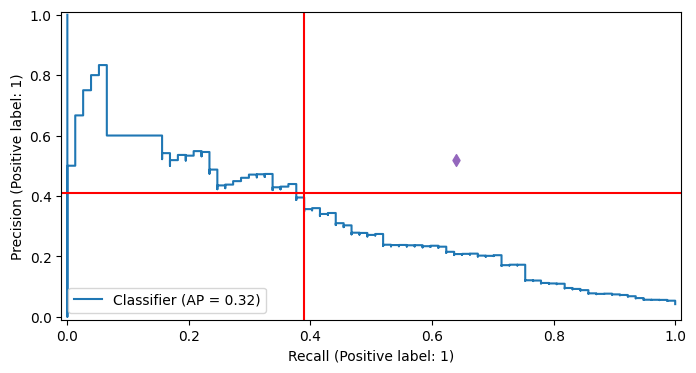

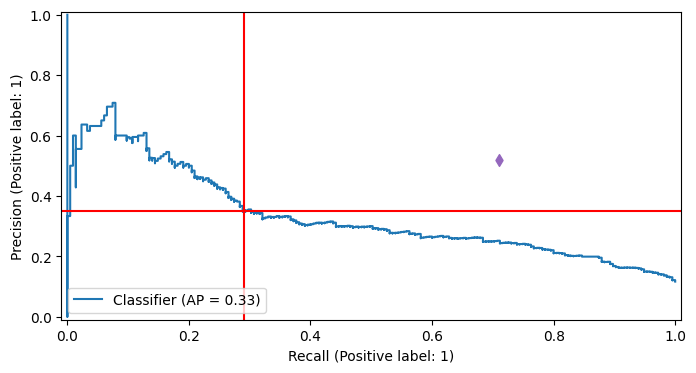

In [38]:
#PR-curve when thresholding class 4
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(yval==4, probas_default[:, 4])
plt.gca().axhline(0.41, color='red')
plt.gca().axvline(0.39, color='red')
plt.gca().scatter(0.64, 0.52, marker='d', color='tab:purple', label='dBERT')

plt.gca().set_aspect('auto')
plt.gcf().set_size_inches(8, 4)
plt.show()

PrecisionRecallDisplay.from_predictions(yval==2, probas_default[:, 2])
plt.gca().axhline(0.35, color='red')
plt.gca().axvline(0.29, color='red')
plt.gca().scatter(0.71, 0.52, marker='d', color='tab:purple', label='dBERT')
plt.gca().set_aspect('auto')
plt.gcf().set_size_inches(8, 4)
plt.show()

### 4. Hierarchical approach

Hierarchcially doing 034/12 -> 0,3,4 / 1,2 *plus* threshold tuning is a bit better than default

**v1 - strength of sentiment**

Worse recal and prec for class 4. Probably because 4s are getting classified into the 123 more readily.

Ought to drill down into nuances of 3/4 instead, ie polarity hierarchy. Also, easier to discern 3 v 4 (and 0 v 1) aot strength of sentiment.

In [39]:
#strong 1: 04, 0: 123
ytrn_strong = np.isin(ytrn, [0, 4]).astype(int)
yval_strong = np.isin(yval, [1, 2, 3]).astype(int)

#strong/pos0  neg4
ytrn_strong_04 = ytrn[ytrn_strong==1] #strong subset, comprising 0, 4
Xtrn_strong = Xtrn.iloc[ytrn_strong==1]

#weak  /pos1  neut2  neg3
ytrn_weak_123 = ytrn[ytrn_strong==0] #weak subset, comprising 0, 1, 2
Xtrn_weak = Xtrn.iloc[ytrn_strong==0]

#Classify 1 (04)  vs  0 (123)
clf_strong = clone(pipeline).fit(Xtrn, ytrn_strong)

#1/strong -> 0 or 4
clf_strong_04 = clone(pipeline).fit(Xtrn_strong, ytrn_strong_04)

#0/weak -> 1, 2, or 3
clf_weak_123 = clone(pipeline).fit(Xtrn_weak, ytrn_weak_123)

#preds
preds_strong = clf_strong.predict(Xval)
preds_strong_04 = clf_strong_04.predict(Xval)
preds_weak_123 = clf_weak_123.predict(Xval)
preds_hier = np.where(preds_strong, preds_strong_04, preds_weak_123)
probas4 = clf_strong_04.predict_proba(Xval)[:, 1]

Records will be trucated to 512 tokens


Map:   0%|          | 0/3698 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (844 > 512). Running this sequence through the model will result in indexing errors


Records will be trucated to 512 tokens


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (844 > 512). Running this sequence through the model will result in indexing errors


Records will be trucated to 512 tokens


Map:   0%|          | 0/2098 [00:00<?, ? examples/s]

Map:   0%|          | 0/1849 [00:00<?, ? examples/s]

Map:   0%|          | 0/1849 [00:00<?, ? examples/s]

Map:   0%|          | 0/1849 [00:00<?, ? examples/s]

Map:   0%|          | 0/1849 [00:00<?, ? examples/s]

**version 2 - polarity**

Doesn't improve class 4 if start off 34 vs rest

A lot better comp to 34 is start off 034 vs rest. So including 0 helps teasing 34 apart. Aot 1|2 + 34.

Starting off with just 4 vs rest has slightly worse curve than regular.

Rm neutral (i.e. 0134 vs 2) no improvement

In [40]:
ytrn_neg = np.isin(ytrn, [0, 3, 4]).astype(int)

ytrn_neg_34 = ytrn[ytrn_neg==1]
Xtrn_neg = Xtrn.iloc[ytrn_neg==1]

ytrn_nonneg_012 = ytrn[ytrn_neg==0]
Xtrn_nonneg = Xtrn.iloc[ytrn_neg==0]

#Classify neg vs nonneg
clf_neg = clone(pipeline).fit(Xtrn, ytrn_neg)
clf_neg_34 = clone(pipeline).fit(Xtrn_neg, ytrn_neg_34)
clf_nonneg_012 = clone(pipeline).fit(Xtrn_nonneg, ytrn_nonneg_012)

#preds
preds_neg = clf_neg.predict(Xval)
preds_neg_34 = clf_neg_34.predict(Xval)
preds_nonneg_012 = clf_nonneg_012.predict(Xval)
preds_hier = np.where(preds_neg, preds_neg_34, preds_nonneg_012)
probas4 = clf_neg_34.predict_proba(Xval)[:, -1]

Records will be trucated to 512 tokens


Map:   0%|          | 0/3698 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (844 > 512). Running this sequence through the model will result in indexing errors


Records will be trucated to 512 tokens


Map:   0%|          | 0/2421 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (844 > 512). Running this sequence through the model will result in indexing errors


Records will be trucated to 512 tokens


Map:   0%|          | 0/1277 [00:00<?, ? examples/s]

Map:   0%|          | 0/1849 [00:00<?, ? examples/s]

Map:   0%|          | 0/1849 [00:00<?, ? examples/s]

Map:   0%|          | 0/1849 [00:00<?, ? examples/s]

Map:   0%|          | 0/1849 [00:00<?, ? examples/s]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~default~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              precision    recall  f1-score   support

           0       0.74      0.75      0.74       723
           1       0.55      0.56      0.56       424
           2       0.35      0.29      0.32       215
           3       0.70      0.73      0.71       410
           4       0.41      0.39      0.40        77

    accuracy                           0.63      1849
   macro avg       0.55      0.54      0.54      1849
weighted avg       0.63      0.63      0.63      1849



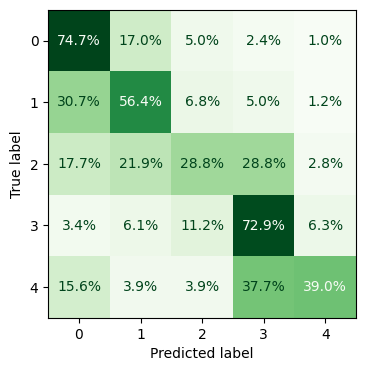

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~hierarchical~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       723
           1       0.53      0.52      0.53       424
           2       0.34      0.30      0.32       215
           3       0.67      0.67      0.67       410
           4       0.38      0.40      0.39        77

    accuracy                           0.61      1849
   macro avg       0.53      0.53      0.53      1849
weighted avg       0.61      0.61      0.61      1849



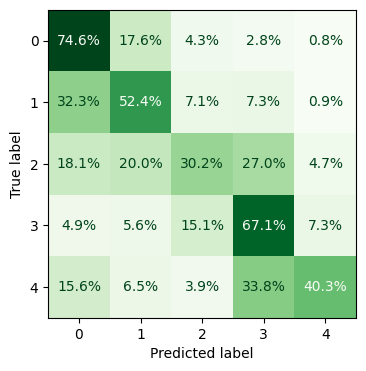

Records will be trucated to 512 tokens


Map:   0%|          | 0/3698 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (844 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/1849 [00:00<?, ? examples/s]

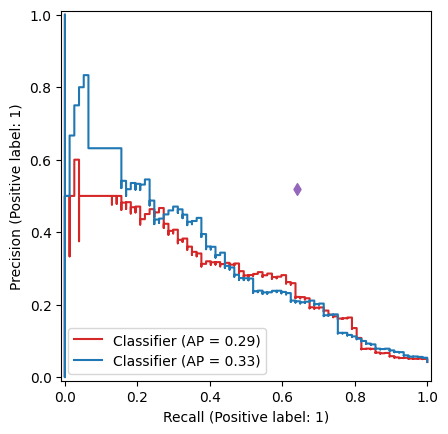

In [41]:
for preds in [preds_default, preds_hier]:
    print(('default' if preds is preds_default else 'hierarchical').center(85, '~'))

    print(classification_report(
        y_true=yval, y_pred=preds
    ))

    ConfusionMatrixDisplay.from_predictions(
        y_true=yval, y_pred=preds,
        normalize='true', cmap='Greens', values_format='.1%', colorbar=False
    )
    plt.gcf().set_size_inches(4, 4)
    plt.show()

PrecisionRecallDisplay.from_predictions(y_true=yval==4, y_pred=probas4, color='tab:red')
PrecisionRecallDisplay.from_predictions(y_true=yval==4, y_pred=pipeline.fit(Xtrn, ytrn).predict_proba(Xval)[:, 4], ax=plt.gca())
plt.gca().scatter(0.64, 0.52, marker='d', color='tab:purple', label='dBERT')

### 5. Custom MLP

Using class-weight balancing results in better recall and prec (38, 41) compared to MLPClassifier (31, 38)


In [42]:
torch.manual_seed(0)
np.random.seed(0)

tfmd_trn = (preproc := clone(tuned_estimators['preprocessor'])).fit_transform(Xtrn, ytrn)
tfmd_val = preproc.transform(Xval)

# Without class-balancing
print(classification_report(
    y_true=yval,
    y_pred=CustomMLP(class_weight=None,).fit(tfmd_trn, ytrn).predict(tfmd_val)
))

#With class balancing
print(classification_report(
    y_true=yval,
    y_pred=CustomMLP(class_weight='balanced',).fit(tfmd_trn, ytrn).predict(tfmd_val)
))

#sklearn mlp
print(classification_report(
    y_true=yval,
    y_pred=tuned_estimators['mlp'].fit(tfmd_trn, ytrn).predict(tfmd_val)
))

Records will be trucated to 512 tokens


Map:   0%|          | 0/3698 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (844 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/1849 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           0       0.71      0.80      0.76       723
           1       0.59      0.51      0.54       424
           2       0.39      0.27      0.32       215
           3       0.67      0.76      0.71       410
           4       0.38      0.23      0.29        77

    accuracy                           0.64      1849
   macro avg       0.55      0.52      0.52      1849
weighted avg       0.62      0.64      0.63      1849

              precision    recall  f1-score   support

           0       0.72      0.77      0.74       723
           1       0.55      0.53      0.54       424
           2       0.41      0.32      0.36       215
           3       0.68      0.71      0.70       410
           4       0.41      0.38      0.39        77

    accuracy                           0.63      1849
   macro avg       0.55      0.54      0.55      1849
weighted avg       0.62      0.63      0.63      1849

              precisio